In [1]:
#in the name of god

In [3]:
import pandas as pd 
import numpy as np
from IPython.display import clear_output
import time
import pickle

import matplotlib.pyplot as plt
from matplotlib.cbook import flatten
import matplotlib.cm as cm
import matplotlib as matplotlib

from fastdtw import fastdtw

def color_map_color(value, cmap_name='coolwarm', vmin=0, vmax=10):
    # norm = plt.Normalize(vmin, vmax)
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)  # PiYG
    rgb = cmap(norm(abs(value)))[:3]  # will return rgba, we take only first 3 so we get rgb
    color = matplotlib.colors.rgb2hex(rgb)
    return color
cl=['r','g','b','c','m','y','k']
color=dict()
for i,el in enumerate(cl):
    color.update({i:el})
#extract the labels for clutering precision its for after clustering
def time_convertor(x):
    s,h,m=0,0,0
    s=round(x%60,2)
    m=int(x/60)
    h=int(m/60)
    m=m%60
    time=str(h)+':'+str(m)+':'+str(s)
    return pd.to_datetime('1970-01-01 '+time)


# Display figures inline in Jupyter notebook
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(15, 5)})

In [ ]:
#data_read
def read_data(number):
    #prepare Dataset gyroscope
    dfg=pd.read_csv(f'{number}\\giroscopio_terra.csv')
    dfg['ts']=pd.to_datetime(dfg.apply(lambda x:(round((x.uptimeNanos-dfg.uptimeNanos[0])/1000000)*1000000),axis=1))
    dm=dfg['ts']
    dfg=dfg.drop('uptimeNanos',1).drop('timestamp',1)
    dfg=dfg.set_index('ts').rename(columns={'x': 'g-x','y': 'g-y','z': 'g-z'})
    #prepare Dataset accelarator
    dfa=pd.read_csv(f'{number}\\acelerometro_terra.csv')
    dfa['ts']=dm
    dfa=dfa.drop('uptimeNanos',1).drop('timestamp',1)
    dfa=dfa.set_index('ts').rename(columns={'x': 'a-x','y': 'a-y','z': 'a-z'})
    dfg['g-x']=dfg.apply(lambda x:(x[0]-min(dfg['g-x']))/(max(dfg['g-x'])-min(dfg['g-x'])),axis=1)
    dfg['g-y']=dfg.apply(lambda x:(x[1]-min(dfg['g-y']))/(max(dfg['g-y'])-min(dfg['g-y'])),axis=1)
    dfg['g-z']=dfg.apply(lambda x:(x[2]-min(dfg['g-z']))/(max(dfg['g-z'])-min(dfg['g-z'])),axis=1)
    dfa['a-x']=dfa.apply(lambda x:(x[0]-min(dfa['a-x']))/(max(dfa['a-x'])-min(dfa['a-x'])),axis=1)
    dfa['a-y']=dfa.apply(lambda x:(x[1]-min(dfa['a-y']))/(max(dfa['a-y'])-min(dfa['a-y'])),axis=1)
    dfa['a-z']=dfa.apply(lambda x:(x[2]-min(dfa['a-z']))/(max(dfa['a-z'])-min(dfa['a-z'])),axis=1)
    return pd.concat([dfa, dfg], axis=1, join='outer')
dfRaw=list()
for num in [16,17,20,21]:
    dfRaw.append((num,read_data(num)))
with open("normalized_data.txt", "wb") as fp:
    pickle.dump(dfRaw, fp)

In [4]:
with open("normalized_data.txt", "rb") as fp:
        dfRaw = pickle.load(fp)
        
def get_label(number):
    label_event_lenght=dict()
    df=pd.read_csv(f'{number}\\groundTruth.csv')
    df['length']=df.en-df.st
    for event , dft in df.groupby('evento'):
        if (event in label_event_lenght):
            label_event_lenght.update({event : label_event_lenght[event]+list(dft.length) })
        else:
            label_event_lenght.update({event : list(dft.length)})

    df['st_time']=df.apply(lambda x:time_convertor(x.st) ,axis=1 )
    df['en_time']=df.apply(lambda x:time_convertor(x.en) ,axis=1 )
    df=df.drop('st',1).drop('en',1).drop('length',1)
    evented_label=list()
    for i in range(len(df)):
        evented_label.append((df.iloc[i][0],df.iloc[i][1],df.iloc[i][2]))
    eve=pd.DataFrame(evented_label)
    eve[3]=[f'evented_label_{number}' for x in evented_label]
    return eve

Ev=[get_label(dfRaw[x][0]) for x in range(len(dfRaw))]
evented_label_All=pd.concat(Ev).reset_index().drop('index',1)


In [5]:
evented_label_All

,0,1,2,3
0,evento_nao_agressivo,1970-01-01 00:00:02.000,1970-01-01 00:00:06.500,evented_label_16
1,curva_direita_agressiva,1970-01-01 00:00:19.500,1970-01-01 00:00:23.500,evented_label_16
2,evento_nao_agressivo,1970-01-01 00:00:30.000,1970-01-01 00:00:33.500,evented_label_16
3,curva_direita_agressiva,1970-01-01 00:01:35.000,1970-01-01 00:01:38.000,evented_label_16
4,curva_esquerda_agressiva,1970-01-01 00:04:07.000,1970-01-01 00:04:11.500,evented_label_16
...,...,...,...,...
64,aceleracao_agressiva,1970-01-01 00:09:25.000,1970-01-01 00:09:27.800,evented_label_21
65,aceleracao_agressiva,1970-01-01 00:11:40.000,1970-01-01 00:11:43.200,evented_label_21
66,aceleracao_agressiva,1970-01-01 00:11:54.000,1970-01-01 00:11:57.000,evented_label_21
67,evento_nao_agressivo,1970-01-01 00:12:31.500,1970-01-01 00:12:34.700,evented_label_21


In [6]:
rate=(dfRaw[0][1].index[11]-dfRaw[0][1].index[10]).total_seconds()

print(f"rate is :{rate}")
pd.DataFrame([(x[0],round(((x[2]-x[1]).total_seconds())/rate)) for x in evented_label_All.iloc]).groupby(0).agg({1:"max"})

rate is :0.02


,1
0,
aceleracao_agressiva,245
curva_direita_agressiva,225
curva_esquerda_agressiva,225
evento_nao_agressivo,225
freada_agressiva,185
troca_faixa_direita_agressiva,125
troca_faixa_esquerda_agressiva,120


In [7]:
pd.DataFrame([(x[0],round(((x[2]-x[1]).total_seconds())/rate)) for x in evented_label_All.iloc]).groupby(0).agg(["max","min","count","mean","std"])

1                                  
                                max  min count        mean        std
0                                                                    
aceleracao_agressiva            245  120    12  180.000000  42.157713
curva_direita_agressiva         225  150    11  173.636364  25.601847
curva_esquerda_agressiva        225  140    11  173.636364  24.908925
evento_nao_agressivo            225  105    14  177.142857  32.148351
freada_agressiva                185   95    12  119.583333  24.721938
troca_faixa_direita_agressiva   125   95     5  111.000000  11.937336
troca_faixa_esquerda_agressiva  120   80     4  105.000000  17.795130

In [8]:
#supervised
window={226:['curva_direita_agressiva','curva_esquerda_agressiva','aceleracao_agressiva'],
        126:['troca_faixa_direita_agressiva','troca_faixa_esquerda_agressiva'],
        186:['freada_agressiva']
       }

In [40]:
#Dont RUN this part
#we should optimize M
#lengh of random event
import random
random.seed(123)
def TempEvent_genarator(df,L,i):
    temp_event=list()
    pointer=0
    stop=False
    #go on timeserise for event extraction
    while stop!=True:
        M=round(random.gauss(0.5,1)*L)
        clear_output(wait=True)
        pointer=pointer + M
        l_min=pointer-int(L/2)
        l_max=pointer+int(L/2)
        if l_max<0:
            l_max=L/2
        if (l_min<0):
            l_min=0
        if (l_max>len(df)):
            l_max=len(df)
            stop=True
        print('extraction ',100*l_max/len(df),' % of ',i,' is complete')
        temp_event.append(df[int(l_min):int(l_max)])
    return temp_event

temp_event=list()
for l,DF in enumerate([x[1] for x in dfRaw]):
    te=list()
    for i,lw in enumerate(window):
        te.append((window[lw],TempEvent_genarator(DF,lw,i+1)))
    temp_event.append(te)

with open("temp_event_new.txt", "wb") as fp:
    pickle.dump(temp_event, fp)

extraction  100.0  % of  3  is complete


In [9]:
with open("temp_event_new.txt", "rb") as fp:
    temp_event = pickle.load(fp)

In [25]:
def has_overlap(A_start, A_end, B_start, B_end):
    #intersection ezafe shavad be inja va khooshgel 
    latest_start = max(A_start, B_start)
    earliest_end = min(A_end, B_end)
    
    return latest_start <= earliest_end

def export_labels(tempevent,evented_label):
    EvL=pd.DataFrame(evented_label)
    Labels={
          226:[],
          126:[],
          186:[],
           }
    for i,wind in enumerate(Labels):
        label=['NAG' for x in tempevent[i][1]]
        for name in tempevent[i][0]:
            el=[(x[1],x[2]) for x in EvL.iloc if x[0]==name]
            for j,te in enumerate(tempevent[i][1]):
                    if len(te)!=0:
                        sta =te.index[0]
                        ena =te.index[-1]
                        for stb,enb in el:
                            if has_overlap(sta,ena,stb,enb):
                                label[j]=name
                    else:
                        label[j]="NA"
                        
        Labels[wind]=label
    return Labels


Data={
      226:[],
      126:[],
      186:[],
       }
for i,temp in enumerate(temp_event):
    TempEv={
              226:[ x for x in temp_event[i][0][1] ],
              126:[ x for x in temp_event[i][1][1] ],
              186:[ x for x in temp_event[i][2][1] ],
               }
    Label=export_labels(temp_event[i],Ev[i])
    #merge together
    for wind in Data:
        for j in range(len(TempEv[wind])):
            Lb=Label[wind][j]
            if Lb != 'NA':
                Data[wind].append((Lb,TempEv[wind][j]))


In [11]:
#dont run this part
#calculate dist of Data from labdeled event
t1=time.time()

k,n=0,0
num_event=dict(evented_label_All.groupby(0).size())
for lenght in window:
    for name in window[lenght]:
        k=k+len(Data[lenght])*num_event[name]

Data_DS={
      226:[],
      126:[],
      186:[],
       }

for wind in Data:
    for label,event in Data[wind]:
         #---------for each Data-distance from events----------
        Y=list()
        for from_event,dfe in evented_label_All.groupby(0):
            if from_event in window[wind]:
                X=list()
                #____for each event_distance from each label_____
                for el in dfe.iloc:
                    clear_output(wait=True)
                    n=n+1
                    print('disstance calculatoin ',round((n/k)*100,4),' %  is complete')
                    if   el[3]=='evented_label_16':
                        X.append(fastdtw(event,dfRaw[0][1][el[1]:el[2]])[0])
                    elif el[3]=='evented_label_17':
                        X.append(fastdtw(event,dfRaw[1][1][el[1]:el[2]])[0])
                    elif el[3]=='evented_label_20':
                        X.append(fastdtw(event,dfRaw[2][1][el[1]:el[2]])[0])
                    elif el[3]=='evented_label_21':
                        X.append(fastdtw(event,dfRaw[3][1][el[1]:el[2]])[0])
                #_________________________________________________
                Y.append((from_event,X))
        Data_DS[wind].append((label,Y))
        #------------------------------------------------------

t2=time.time()
with open("Disstance_new.txt", "wb") as fp:
    pickle.dump(Data_DS, fp)

print(round((t2-t1)/60) ,'min has time for calculaton distant')

disstance calculatoin  100.0  %  is complete
386 min has time for calculaton distant


In [26]:
with open("Disstance_new.txt", "rb") as fp:
    Data_DS = pickle.load(fp)

In [27]:
#prepare dataset for labeling
TrainData=dict()
for win in Data_DS:
    x=Data_DS[win]
    dumy_list=list()
    for events in x:
        dumy_dict=dict()
        dumy_dict.update({'label':events[0]})
        for name , event in events[1]:
            for tag,number in enumerate(event):
                dumy_dict.update({name+"_"+str(tag):number})
        dumy_list.append(dumy_dict)
    TrainData.update({win:pd.DataFrame(dumy_list)})

In [28]:
TrainData[186].head(30)

,label,freada_agressiva_0,freada_agressiva_1,freada_agressiva_2,freada_agressiva_3,freada_agressiva_4,freada_agressiva_5,freada_agressiva_6,freada_agressiva_7,freada_agressiva_8,freada_agressiva_9,freada_agressiva_10,freada_agressiva_11
0,NAG,123.031933,101.863303,114.760261,104.110583,112.607254,132.221349,110.077386,157.350290,100.376590,99.589616,125.543938,89.673959
1,NAG,123.031933,101.863303,114.760261,104.110583,112.607254,132.221349,110.077386,157.350290,100.376590,99.589616,125.543938,89.673959
2,NAG,119.645240,98.866172,111.790702,101.768855,110.761016,130.311210,104.896967,149.458247,95.017975,94.229907,120.147591,84.573640
3,NAG,123.031933,101.863303,114.760261,104.110583,112.607254,132.221349,110.077386,157.350290,100.376590,99.589616,125.543938,89.673959
4,NAG,123.031933,101.863303,114.760261,104.110583,112.607254,132.221349,110.077386,157.350290,100.376590,99.589616,125.543938,89.673959
5,NAG,123.031933,101.863303,114.760261,104.110583,112.607254,132.221349,110.077386,157.350290,100.376590,99.589616,125.543938,89.673959
6,NAG,123.031933,101.863303,114.760261,104.110583,112.607254,132.221349,110.077386,157.350290,100.376590,99.589616,125.543938,89.673959
7,NAG,123.031933,101.863303,114.760261,104.110583,112.607254,132.221349,110.077386,157.350290,100.376590,99.589616,125.543938,89.673959
8,NAG,123.031933,101.863303,114.760261,104.110583,112.607254,132.221349,110.077386,157.350290,100.376590,99.589616,125.543938,89.673959
9,NAG,123.031933,101.863303,114.760261,104.110583,112.607254,132.221349,110.077386,157.350290,100.376590,99.589616,125.543938,89.673959


In [29]:
#normalize Train Data
#Balance it 
from copy import deepcopy
import six
import sys
sys.modules['sklearn.externals.six'] = six
from id3 import Id3Estimator, export_text
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score, classification_report,precision_recall_fscore_support
from sklearn.model_selection import train_test_split


wid=186
Max_depth=3

data=TrainData[wid].drop('label',1)
label=TrainData[wid].label
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.3, random_state=123)

estimator1 = Id3Estimator(max_depth=Max_depth, min_samples_split=1, prune=True,
                        gain_ratio=True, min_entropy_decrease=0, is_repeating=True)

estimator1.fit(X_train,y_train , check_input=True)

precision_recall_fscore_support(y_test, estimator1.predict(X_test),average='macro')[2]
print(classification_report(y_test, estimator1.predict(X_test)))

precision_recall_fscore_support(y_train, estimator1.predict(X_train),average='macro')[2]
print(classification_report(y_train, estimator1.predict(X_train)))


                  precision    recall  f1-score   support

             NAG       0.97      1.00      0.99      2298
freada_agressiva       1.00      0.21      0.34        78

        accuracy                           0.97      2376
       macro avg       0.99      0.60      0.66      2376
    weighted avg       0.97      0.97      0.97      2376

                  precision    recall  f1-score   support

             NAG       0.97      1.00      0.98      5313
freada_agressiva       1.00      0.18      0.31       229

        accuracy                           0.97      5542
       macro avg       0.98      0.59      0.65      5542
    weighted avg       0.97      0.97      0.95      5542



In [30]:
feature_names=TrainData[wid].columns[1:]
print(export_text(estimator1.tree_, feature_names))


freada_agressiva_8 <=23.61: freada_agressiva (15) 
freada_agressiva_8 >23.61
|   freada_agressiva_10 <=22.27: freada_agressiva (7) 
|   freada_agressiva_10 >22.27
|   |   freada_agressiva_11 <=26.90: freada_agressiva (5) 
|   |   freada_agressiva_11 >26.90: NAG (3726/126) 



In [41]:
#normalize Train Data
#Balance it 
from copy import deepcopy
import six
import sys
sys.modules['sklearn.externals.six'] = six
from id3 import Id3Estimator, export_text
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score, classification_report,precision_recall_fscore_support
from sklearn.model_selection import train_test_split


wid=186
Max_depth=3

data=TrainData[wid].drop('label',1)
label=TrainData[wid].label
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.3, random_state=123)

estimator1 = Id3Estimator(max_depth=Max_depth, min_samples_split=1, prune=True,
                        gain_ratio=True, min_entropy_decrease=0, is_repeating=True)

estimator1.fit(X_train,y_train , check_input=True)

precision_recall_fscore_support(y_test, estimator1.predict(X_test),average='macro')[2]
print(classification_report(y_test, estimator1.predict(X_test)))

precision_recall_fscore_support(y_train, estimator1.predict(X_train),average='macro')[2]
print(classification_report(y_train, estimator1.predict(X_train)))
feature_names=TrainData[wid].columns[1:]
print(export_text(estimator1.tree_, feature_names))

                  precision    recall  f1-score   support

             NAG       0.97      1.00      0.99      2298
freada_agressiva       0.81      0.22      0.34        78

        accuracy                           0.97      2376
       macro avg       0.89      0.61      0.66      2376
    weighted avg       0.97      0.97      0.96      2376

                  precision    recall  f1-score   support

             NAG       0.97      1.00      0.98      5313
freada_agressiva       0.92      0.25      0.39       229

        accuracy                           0.97      5542
       macro avg       0.94      0.62      0.69      5542
    weighted avg       0.97      0.97      0.96      5542


freada_agressiva_10 <=22.18: freada_agressiva (8) 
freada_agressiva_10 >22.18
|   freada_agressiva_11 <=26.08: freada_agressiva (8) 
|   freada_agressiva_11 >26.08
|   |   freada_agressiva_6 <=36.49: freada_agressiva (26/3) 
|   |   freada_agressiva_6 >36.49: NAG (3716/118) 



In [29]:
import numpy as np
from fastdtw import fastdtw

x = np.array([[1,1], [2,2], [3,3], [4,4], [5,5]])
y = np.array([[1,2], [2,2], [2,3]])
distance, path = fastdtw(x, y)
print(distance)

10.0


In [54]:
#dont run this part
from copy import deepcopy
import six
import sys
sys.modules['sklearn.externals.six'] = six
from id3 import Id3Estimator, export_text
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

t1=time.time()
n,k=0,12*50

Result={
      226:[],
      126:[],
      186:[],
       }
for wid in Result:
    data=TrainData[wid].drop('label',1)
    label=TrainData[wid].label
    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.3, random_state=123)
    for Max_depth in range(1,20):
        estimator = Id3Estimator(max_depth=Max_depth, min_samples_split=1, prune=True,
                        gain_ratio=True, min_entropy_decrease=0, is_repeating=True)
        #run it in itaraion for the best trees
        NUMBER_OF_TEST=5
        temp=list()
        for NT in range(NUMBER_OF_TEST):
            clear_output(wait=True)
            n=n+1
            print('disstance calculatoin ',round((n/k)*100,4),' %  is complete')
            estimator.fit(X_train,y_train , check_input=True)
            ACC=precision_recall_fscore_support(y_train, estimator.predict(X_train),average='macro')[2]
            temp.append((ACC,deepcopy(estimator)))
        temp_index=[(x[0],i) for i,x in enumerate(temp)]
        temp_index.sort()
        Acc=temp[temp_index[-1][1]][0]
        estimator=temp[temp_index[-1][1]][1]
        Result[wid].append(((X_train, X_test, y_train, y_test),deepcopy(estimator)))

with open("Model_new.txt", "wb") as fp:
    pickle.dump(Result, fp)
t2=time.time()
print(round((t2-t1)/60) ,'min has time for calculaton Model')

disstance calculatoin  25.5  %  is complete
67 min has time for calculaton Model


In [8]:
from copy import deepcopy
import six
import sys
sys.modules['sklearn.externals.six'] = six
from id3 import Id3Estimator, export_text
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, classification_report,precision_recall_fscore_support

with open("Model_new.txt", "rb") as fp:
    Result = pickle.load(fp)

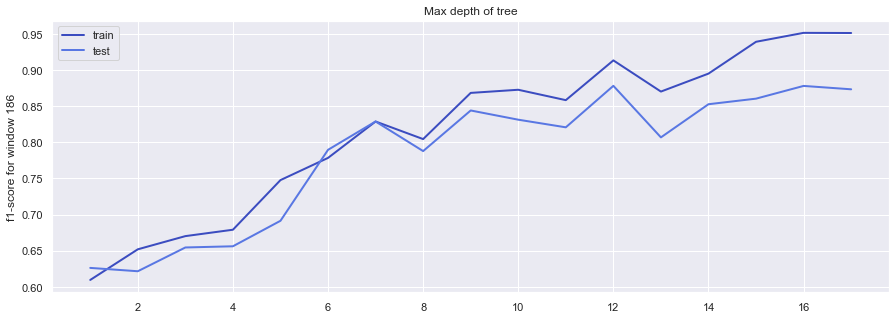

In [9]:
wid=186
X=range(1,18)

test=[]
train=[]

for max_depth in X:
    es=Result[wid][max_depth-1][1]
    X_tr, X_te, y_tr, y_te=Result[wid][max_depth-1][0]
    train.append(precision_recall_fscore_support(y_tr, es.predict(X_tr),average='macro')[2])
    test.append(precision_recall_fscore_support(y_te, es.predict(X_te),average='macro')[2])
    
fig, ax = plt.subplots()
for Lambda,chart in enumerate([train,test]):
    ax.plot(X,chart, linestyle='-', linewidth=2,c=color_map_color(Lambda),label=['train','test'][Lambda])
ax.set_title('Max depth of tree')
ax.set_ylabel('f1-score for window 186')
ax.legend();
plt.show() 

In [16]:
max_depth=12
wid =186

es=Result[wid][max_depth-1][1]
X_tr, X_te, y_tr, y_te=Result[wid][max_depth-1][0]
print("----------train-------------------------------------------")
print(classification_report(y_tr, es.predict(X_tr)))
print("----------test--------------------------------------------")
print(classification_report(y_te, es.predict(X_te)))


----------train-------------------------------------------
                  precision    recall  f1-score   support

             NAG       0.99      1.00      0.99      5313
freada_agressiva       0.95      0.74      0.83       229

        accuracy                           0.99      5542
       macro avg       0.97      0.87      0.91      5542
    weighted avg       0.99      0.99      0.99      5542

----------test--------------------------------------------
                  precision    recall  f1-score   support

             NAG       0.99      1.00      0.99      2298
freada_agressiva       0.83      0.71      0.76        78

        accuracy                           0.99      2376
       macro avg       0.91      0.85      0.88      2376
    weighted avg       0.98      0.99      0.99      2376



In [31]:
feature_names=TrainData[wid].columns[1:]
print(export_text(es.tree_, feature_names))


freada_agressiva_7 <=37.41: freada_agressiva (25) 
freada_agressiva_7 >37.41
|   freada_agressiva_10 <=22.18: freada_agressiva (7) 
|   freada_agressiva_10 >22.18
|   |   freada_agressiva_11 <=26.08: freada_agressiva (7) 
|   |   freada_agressiva_11 >26.08
|   |   |   freada_agressiva_6 <=35.74
|   |   |   |   freada_agressiva_0 <=127.38: NAG (2) 
|   |   |   |   freada_agressiva_0 >127.38: freada_agressiva (5) 
|   |   |   freada_agressiva_6 >35.74
|   |   |   |   freada_agressiva_3 <=120.19
|   |   |   |   |   freada_agressiva_4 <=61.46: freada_agressiva (18) 
|   |   |   |   |   freada_agressiva_4 >61.46
|   |   |   |   |   |   freada_agressiva_0 <=69.70
|   |   |   |   |   |   |   freada_agressiva_3 <=84.52
|   |   |   |   |   |   |   |   freada_agressiva_0 <=63.54: freada_agressiva (3) 
|   |   |   |   |   |   |   |   freada_agressiva_0 >63.54: NAG (9) 
|   |   |   |   |   |   |   freada_agressiva_3 >84.52
|   |   |   |   |   |   |   |   freada_agressiva_0 <=69.09: freada_agressi

No handles with labels found to put in legend.


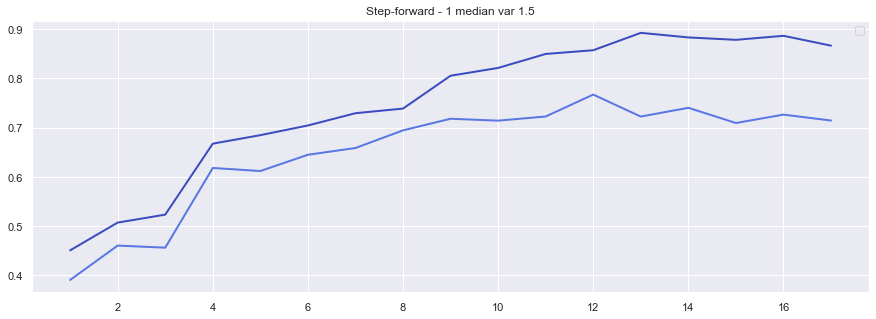

In [46]:
wid=126
X=range(1,18)

test=[]
train=[]

for max_depth in X:
    es=Result[wid][max_depth-1][1]
    X_tr, X_te, y_tr, y_te=Result[wid][max_depth-1][0]
    train.append(precision_recall_fscore_support(y_tr, es.predict(X_tr),average='macro')[2])
    test.append(precision_recall_fscore_support(y_te, es.predict(X_te),average='macro')[2])
    
fig, ax = plt.subplots()
for Lambda,chart in enumerate([train,test]):
    ax.plot(X,chart, linestyle='-', linewidth=2,c=color_map_color(Lambda))#,label=f"lambda {[Lambda][0]:.2f}")
ax.set_title('Step-forward - 1 median var 1.5')
ax.legend();
plt.show() 

No handles with labels found to put in legend.


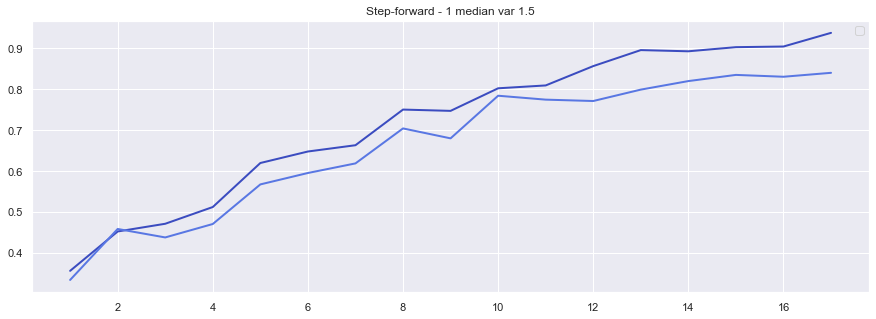

In [62]:
wid=226
X=range(1,18)

test=[]
train=[]

for max_depth in X:
    es=Result[wid][max_depth-1][1]
    X_tr, X_te, y_tr, y_te=Result[wid][max_depth-1][0]
    train.append(precision_recall_fscore_support(y_tr, es.predict(X_tr),average='macro')[2])
    test.append(precision_recall_fscore_support(y_te, es.predict(X_te),average='macro')[2])
    
fig, ax = plt.subplots()
for Lambda,chart in enumerate([train,test]):
    ax.plot(X,chart, linestyle='-', linewidth=2,c=color_map_color(Lambda))#,label=f"lambda {[Lambda][0]:.2f}")
ax.set_title('Step-forward - 1 median var 1.5')
ax.legend();
plt.show() 

In [26]:
wid=186
X=range(1,18)

test=[]
train=[]

for max_depth in X:
    es=Result[wid][max_depth-1][1]
    X_tr, X_te, y_tr, y_te=Result[wid][max_depth-1][0]
    train.append(precision_recall_fscore_support(y_tr, es.predict(X_tr),average='macro')[2])
    test.append(precision_recall_fscore_support(y_te, es.predict(X_te),average='macro')[2])
    
fig, ax = plt.subplots()
for Lambda,chart in enumerate([train,test]):
    ax.plot(X,chart, linestyle='-', linewidth=2,c=color_map_color(Lambda))#,label=f"lambda {[Lambda][0]:.2f}")
#ax.set_title('Step-forward - 1 median var 1.5')
ax.legend();
plt.show() 

0.9888721804511278
                  precision    recall  f1-score   support

             NAG       0.99      1.00      0.99      3234
freada_agressiva       0.90      0.67      0.77        91

        accuracy                           0.99      3325
       macro avg       0.94      0.83      0.88      3325
    weighted avg       0.99      0.99      0.99      3325



In [27]:
wid=186
X=range(1,18)

test=[]
train=[]

for max_depth in X:
    es=Result[wid][max_depth-1][1]
    X_tr, X_te, y_tr, y_te=Result[wid][max_depth-1][0]
    train.append(precision_recall_fscore_support(y_tr, es.predict(X_tr),average='macro')[2])
    test.append(precision_recall_fscore_support(y_te, es.predict(X_te),average='macro')[2])
    
fig, ax = plt.subplots()
for Lambda,chart in enumerate([train,test]):
    ax.plot(X,chart, linestyle='-', linewidth=2,c=color_map_color(Lambda))#,label=f"lambda {[Lambda][0]:.2f}")
#ax.set_title('Step-forward - 1 median var 1.5')
ax.legend();
plt.show() 

0.9534528805799313
                          precision    recall  f1-score   support

                     NAG       0.95      1.00      0.97      2379
    aceleracao_agressiva       0.96      0.27      0.42        81
 curva_direita_agressiva       1.00      0.52      0.68        62
curva_esquerda_agressiva       0.99      0.69      0.81        99

                accuracy                           0.95      2621
               macro avg       0.97      0.62      0.72      2621
            weighted avg       0.95      0.95      0.94      2621



In [ ]:
#overfit model!
Overfit_model={
      226:[],
      126:[],
      186:[],
       }

for wid in Overfit_model:
    data=TrainData[wid].drop('label',1)
    label=TrainData[wid].label
    #
    estimator = Id3Estimator(max_depth=100, min_samples_split=1, prune=True,
                    gain_ratio=True, min_entropy_decrease=0, is_repeating=True)
    #run it in itaraion for the best trees
    NUMBER_OF_TEST=10
    temp=list()
    for NT in range(NUMBER_OF_TEST):
        estimator.fit(data,label , check_input=True)
        ACC=accuracy_score(y_true=label,y_pred=estimator.predict(data))
        temp.append((ACC,deepcopy(estimator)))
    temp_index=[(x[0],i) for i,x in enumerate(temp)]
    temp_index.sort()
    Acc=temp[temp_index[-1][1]][0]
    estimator=temp[temp_index[-1][1]][1]
    Overfit_model[wid]=(Acc,deepcopy(estimator))

with open("TrainData_test_l_1.txt", "wb") as fp:
    pickle.dump((Overfit_model), fp)



In [ ]:
wid=226
data=TrainData[wid].drop('label',1)
label=TrainData[wid].label
print(classification_report(label, Overfit_model[wid][1].predict(data)))
#its completely ovefit

In [ ]:
for in wid window:
    estimator=Result[wid][5][1]
    x={x for x in estimator.predict(Test_new[wid])}
    print(f" {wid} is : {x}")


In [ ]:
import re
x=data.columns[30]
rep=re.compile(r'(\w+)(\d+)')
mo=rep.findall(x)[0]
print(mo[])


In [ ]:
#plot charts for find the optimom
Y1=[x[0]for x in Result[226]]
Y2=[x[0]for x in Result[186]]
Y3=[x[0]for x in Result[126]]

X=range(1,11)

fig, ax = plt.subplots()

ax.plot(X,Y1, linestyle='-', linewidth=2,c='r')
ax.plot(X,Y2, linestyle='-', linewidth=2,c='g')
ax.plot(X,Y3, linestyle='-', linewidth=2,c='b')

ax.legend();
plt.show() 